In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets from the curated folder
suburb_growth_path = '../../data/curated/suburb_rent_growth_predictions.csv'
aggregate_property_path = '../../data/curated/aggregate_property_suburb.csv'

# Load the CSVs into DataFrames
suburb_growth_df = pd.read_csv(suburb_growth_path)
aggregate_property_df = pd.read_csv(aggregate_property_path)

In [2]:
# Show top 10 growthing subrub
top_10_growth_df = suburb_growth_df.sort_values(by='annual growth rate', ascending=False).head(10)

top_10_growth_df

,suburb,annual growth rate,2024 price,2025 price,2026 price
109,Mt Eliza-Mornington-Mt Martha,19.062922,591.354777,610.417698,629.480620
141,Torquay,18.216512,597.073978,615.290489,633.507001
43,Brighton East,17.662085,780.519551,798.181636,815.843721
106,Dromana-Portsea,16.970033,486.415735,503.385768,520.355801
135,Ocean Grove-Barwon Heads,16.123965,516.791386,532.915350,549.039315
108,Hastings-Flinders,15.237770,472.226458,487.464228,502.701998
144,Warragul,14.208999,419.362845,433.571843,447.780842
127,Benalla,13.741313,363.392897,377.134210,390.875523
115,Lara,13.401178,459.683984,473.085162,486.486340
64,Yarraville-Seddon,12.977717,526.762785,539.740502,552.718219


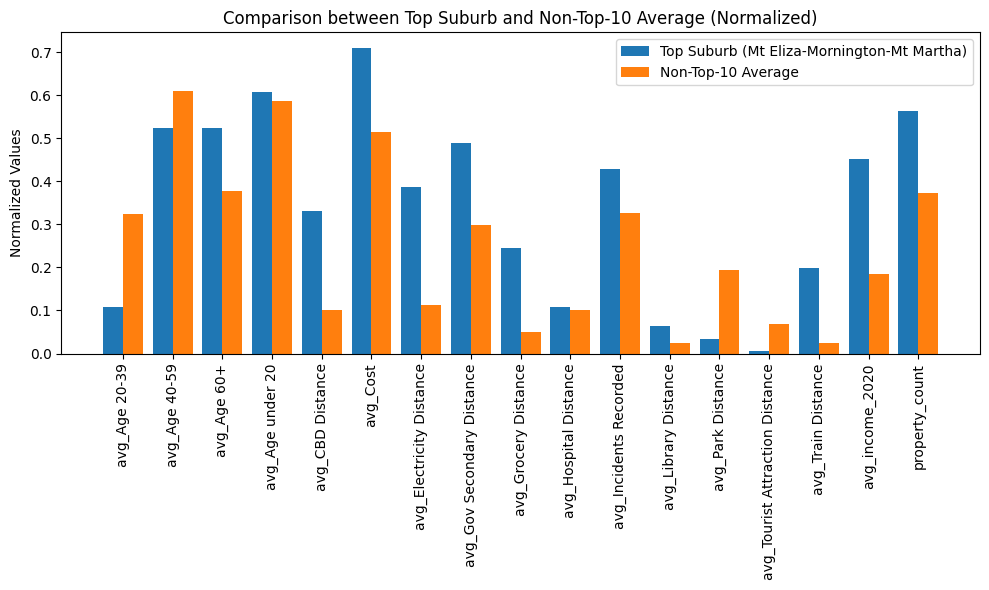

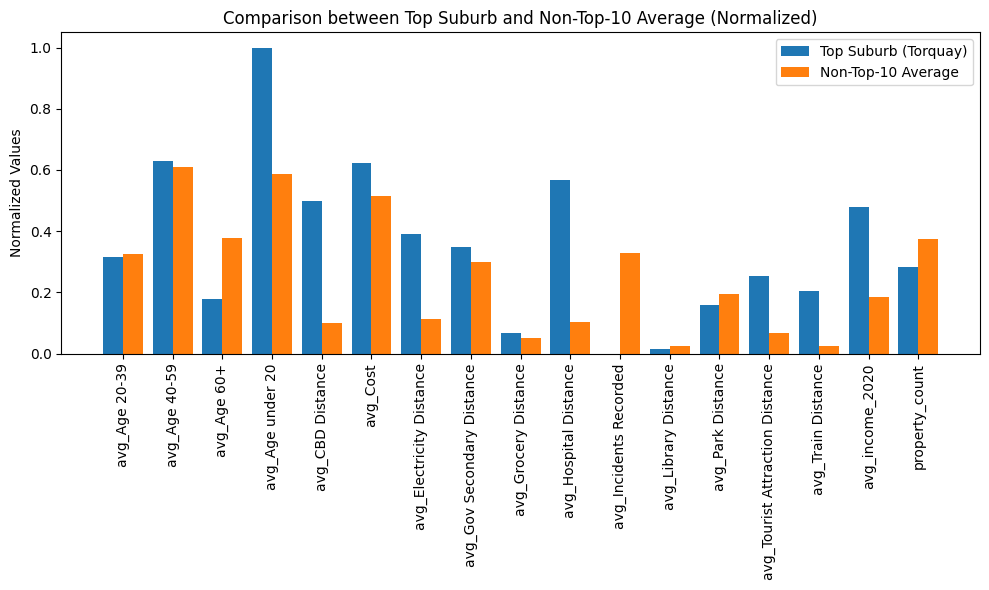

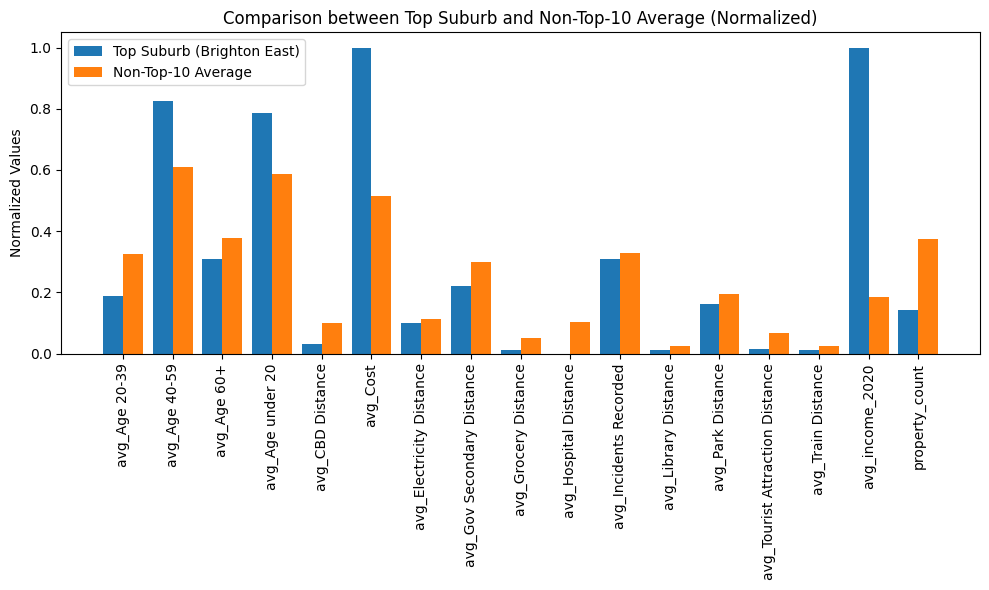

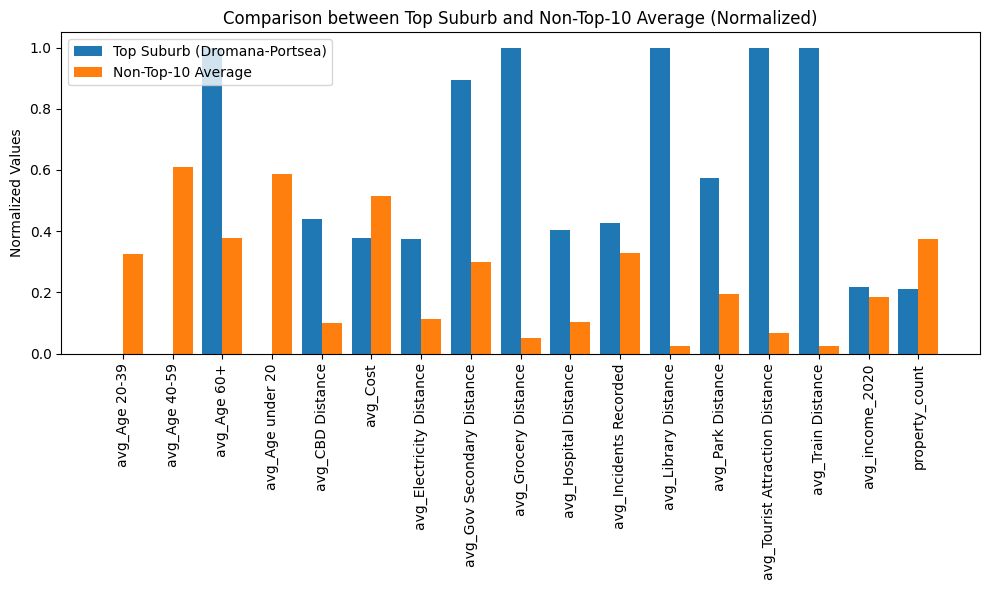

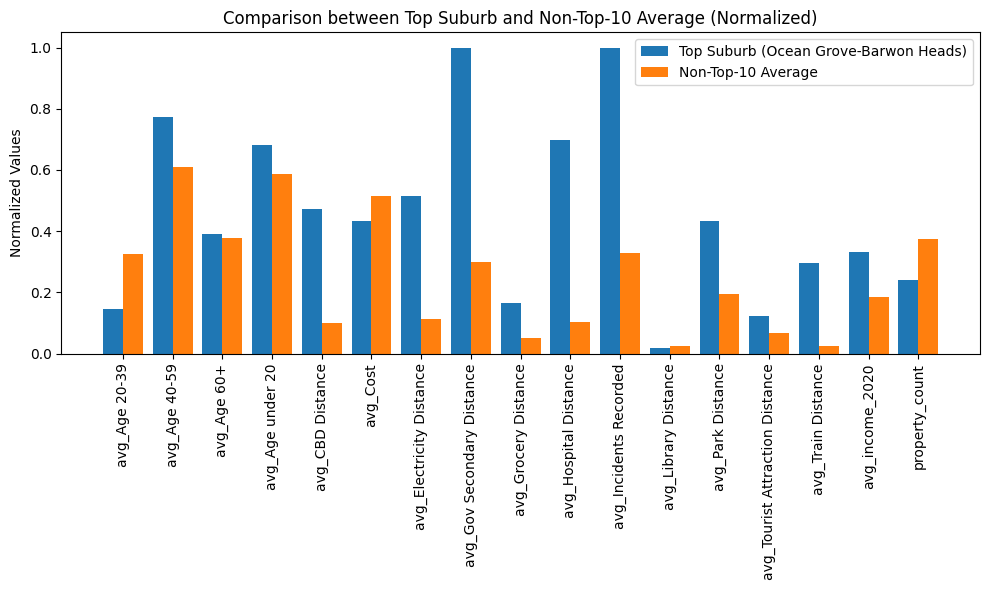

In [8]:
# Min-max normalization function across the entire dataset
def normalize_across_dataset(df, feature_columns):
    return (df[feature_columns] - df[feature_columns].min()) / (df[feature_columns].max() - df[feature_columns].min())

# Sort by growth rate and get the top 10 suburbs
top_10_growth_df = suburb_growth_df.sort_values(by='annual growth rate', ascending=False).head(10)

# Merge the top 10 growth suburbs with the aggregate data on suburb names
top_10_merged_df = top_10_growth_df.merge(aggregate_property_df, left_on='suburb', right_on='Suburb', how='left')

# Get the columns that are features to normalize (ignore columns like 'suburb', 'annual growth rate', etc.)
feature_columns = aggregate_property_df.columns.difference(['Unnamed: 0', 'Suburb', 'suburb', 'annual growth rate', '2024 price', '2025 price', '2026 price'])

# Normalize the entire dataset based on these feature columns
aggregate_property_normalized = aggregate_property_df.copy()
aggregate_property_normalized[feature_columns] = normalize_across_dataset(aggregate_property_df, feature_columns)

# Normalize the top 10 growth suburbs based on the same scaling
top_10_normalized = top_10_merged_df.copy()
top_10_normalized[feature_columns] = normalize_across_dataset(top_10_merged_df, feature_columns)

# Calculate the average of the non-top-10 suburbs (normalized)
non_top_10_df = aggregate_property_normalized[~aggregate_property_normalized['Suburb'].isin(top_10_growth_df['suburb'])]
non_top_10_avg = non_top_10_df[feature_columns].mean()

# Prepare for comparison with the average of non-top-10 suburbs
comparisons = []

for index, top_suburb in top_10_normalized.iterrows():
    top_suburb_stats = top_suburb[feature_columns].dropna()

    # Ensure both are of the same length by selecting common metrics
    common_metrics = top_suburb_stats.index.intersection(non_top_10_avg.index)

    # Create comparison DataFrame with normalized values
    comparison = pd.DataFrame({
        'Metric': common_metrics,
        f'Top Suburb ({top_suburb["Suburb"]})': top_suburb_stats[common_metrics].values,
        'Non-Top-10 Average': non_top_10_avg[common_metrics].values
    })
    comparisons.append(comparison)

# Visualization function to compare each top suburb with the average of non-top-10 suburbs
def visualize_comparison(comparison_df):
    metrics = comparison_df['Metric']
    top_suburb_values = comparison_df.iloc[:, 1]
    non_top_10_avg_values = comparison_df.iloc[:, 2]
    
    # Create a bar chart for the comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.4  # width of the bars
    
    # Positions for the bars
    indices = range(len(metrics))
    
    # Bar plots for top suburb and non-top-10 average
    ax.bar(indices, top_suburb_values, width=width, label=comparison_df.columns[1], align='center')
    ax.bar([i + width for i in indices], non_top_10_avg_values, width=width, label=comparison_df.columns[2], align='center')
    
    # Adding labels and titles
    ax.set_xticks([i + width / 2 for i in indices])
    ax.set_xticklabels(metrics, rotation=90)
    ax.set_ylabel('Normalized Values')
    ax.set_title('Comparison between Top Suburb and Non-Top-10 Average (Normalized)')
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Visualize comparisons for the top 10 suburbs
for i in range(5):
    visualize_comparison(comparisons[i])
